# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math 
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None  # default='warn'
#pd.options.display.max_columns = None

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Overview of the general demographics data:')
print("-- Shape: ", azdias.shape)

print("-- Data head:")
display(azdias.head())

Overview of the general demographics data:
-- Shape:  (891221, 85)
-- Data head:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
dict_replacements = {}
for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    missing_items = missing_or_unknown.strip('[]').split(',')
    if(len(missing_items)>0):
        dict_replacements[attribute] = len(azdias[azdias[attribute].isin(missing_items)])
        azdias.loc[azdias[attribute].isin(missing_items), attribute] = np.nan

# insights
print("number of entries updated with NaN:")
display(dict_replacements)

total_entries = azdias.shape[0]*azdias.shape[1]
total_missing = sum(dict_replacements.values())
percentage = total_missing/total_entries
print('{:-9} total missing entries ({:2.2%})'.format(total_missing, percentage))
      
print("updated data (head):")
azdias.head(10)


number of entries updated with NaN:


{'AGER_TYP': 685843,
 'ALTERSKATEGORIE_GROB': 2881,
 'ANREDE_KZ': 0,
 'CJT_GESAMTTYP': 0,
 'FINANZ_MINIMALIST': 0,
 'FINANZ_SPARER': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_UNAUFFAELLIGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'GEBURTSJAHR': 392318,
 'GFK_URLAUBERTYP': 0,
 'GREEN_AVANTGARDE': 0,
 'HEALTH_TYP': 111196,
 'LP_LEBENSPHASE_FEIN': 92778,
 'LP_LEBENSPHASE_GROB': 89718,
 'LP_FAMILIE_FEIN': 72938,
 'LP_FAMILIE_GROB': 72938,
 'LP_STATUS_FEIN': 0,
 'LP_STATUS_GROB': 0,
 'NATIONALITAET_KZ': 108315,
 'PRAEGENDE_JUGENDJAHRE': 108164,
 'RETOURTYP_BK_S': 0,
 'SEMIO_SOZ': 0,
 'SEMIO_FAM': 0,
 'SEMIO_REL': 0,
 'SEMIO_MAT': 0,
 'SEMIO_VERT': 0,
 'SEMIO_LUST': 0,
 'SEMIO_ERL': 0,
 'SEMIO_KULT': 0,
 'SEMIO_RAT': 0,
 'SEMIO_KRIT': 0,
 'SEMIO_DOM': 0,
 'SEMIO_KAEM': 0,
 'SEMIO_PFLICHT': 0,
 'SEMIO_TRADV': 0,
 'SHOPPER_TYP': 111196,
 'SOHO_KZ': 0,
 'TITEL_KZ': 815562,
 'VERS_TYP': 111196,
 'ZABEOTYP': 0,
 'ALTER_HH': 236768,
 'ANZ_PERSONEN': 0,
 'ANZ_TITEL': 0,
 'HH_

  3477091 total missing entries (4.59%)
updated data (head):


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

dict_nans = {}
for attribute in feat_info['attribute']:
    dict_nans[attribute] = azdias[attribute].isnull().sum(axis=0)

missing_data_stats_df = pd.DataFrame([dict_nans, dict_replacements]).T
missing_data_stats_df.columns = ["total missing", "converted missing"]
missing_data_stats_df["initial missing"] = missing_data_stats_df["total missing"]-missing_data_stats_df["converted missing"]
missing_data_stats_df["percentage of total missing"] = np.floor(1000 * missing_data_stats_df["total missing"] / azdias.shape[0])/10

print('a total of {:-2} out of {:-2} columns have missing entries.'.format(len(missing_data_stats_df[missing_data_stats_df["total missing"]>0]), missing_data_stats_df.shape[0]))
display(missing_data_stats_df)

a total of 61 out of 85 columns have missing entries.


,total missing,converted missing,initial missing,percentage of total missing
AGER_TYP,685843,685843,0,76.9
ALTERSKATEGORIE_GROB,2881,2881,0,0.3
ALTER_HH,310267,236768,73499,34.8
ANREDE_KZ,0,0,0,0.0
ANZ_HAUSHALTE_AKTIV,99611,6463,93148,11.1
ANZ_HH_TITEL,97008,0,97008,10.8
ANZ_PERSONEN,73499,0,73499,8.2
ANZ_TITEL,73499,0,73499,8.2
ARBEIT,97375,159,97216,10.9
BALLRAUM,93740,0,93740,10.5


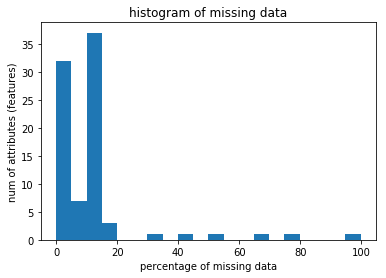

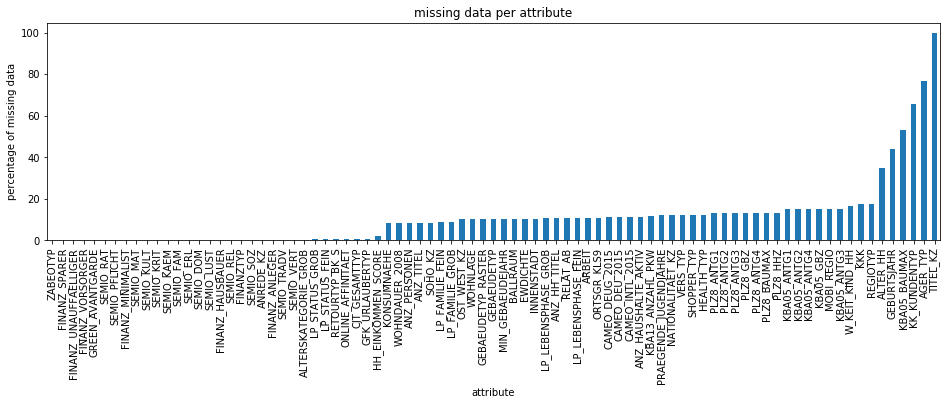

In [6]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data_stats_df["percentage of total missing"], bins=20)
plt.ylabel('num of attributes (features)')
plt.xlabel('percentage of missing data')
plt.title('histogram of missing data')
plt.show()

missing_data_stats_df.sort_values("percentage of total missing").plot.bar(y="percentage of total missing", rot=90, figsize=(16,4), legend=False, color='#1f77b4')
plt.ylabel('percentage of missing data')
plt.xlabel('attribute')
plt.title('missing data per attribute')
plt.show()



In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outlier_cols = missing_data_stats_df[missing_data_stats_df["percentage of total missing"] > 20]

print("outlier columns (attributes) to be dropped:")
display(outlier_cols)

# dropping the outlier attributes
print("data after dropping the outlier attributes (head):")
azdias.drop(outlier_cols.index, axis=1, inplace=True)
display(azdias.head())

outlier columns (attributes) to be dropped:


,total missing,converted missing,initial missing,percentage of total missing
AGER_TYP,685843,685843,0,76.9
ALTER_HH,310267,236768,73499,34.8
GEBURTSJAHR,392318,392318,0,44.0
KBA05_BAUMAX,476524,343200,133324,53.4
KK_KUNDENTYP,584612,0,584612,65.5
TITEL_KZ,889061,815562,73499,99.7


data after dropping the outlier attributes (head):


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

61 of the 85 columns have missing data. The majority of these columns have around 20% missing data. However, 6 of these columns have over 34% missing data, and these columns would be considered the outliers. These columns are: AGER_TYP, ALTER_HH, GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, and TITEL_KZ. Since so much of their data is missing, including these columns in the analysis would influence the results, so they should be taken out. That leaves 79 columns with closer to 20% missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

268012 out of 891221 rows (30.07%) have missing entries.


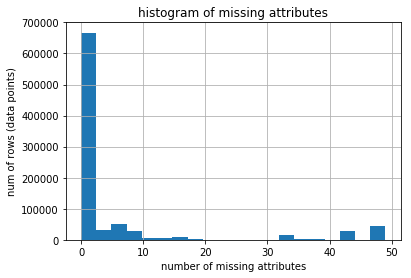

In [8]:
# How much data is missing in each row of the dataset?

num_data_with_missing_attr = sum(azdias.isnull().any(axis=1))
percentage = num_data_with_missing_attr/azdias.shape[0]
print('{:-2} out of {:-2} rows ({:2.2%}) have missing entries.'.format(num_data_with_missing_attr, azdias.shape[0], percentage))

data_with_missing_attr = azdias.isnull().sum(axis=1)
data_with_missing_attr.hist(bins=20)
plt.ylabel('num of rows (data points)')
plt.xlabel('number of missing attributes')
plt.title('histogram of missing attributes')
plt.show()

In [9]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

split_threshold = 30
azdias_low_missing = azdias[azdias.isnull().sum(axis=1) <= 25]
azdias_high_missing = azdias[azdias.isnull().sum(axis=1) > 25]

print('result for a split threshold of ', split_threshold, ' missing attributes:')
print('-- subframe with low missing data has {:-2} data points ({:2.2%} of all)'.format(azdias_low_missing.shape[0], azdias_low_missing.shape[0]/azdias.shape[0]))
print('-- subframe with high missing data has {:-2} data points ({:2.2%} of all)'.format(azdias_high_missing.shape[0], azdias_high_missing.shape[0]/azdias.shape[0]))

result for a split threshold of  30  missing attributes:
-- subframe with low missing data has 797961 data points (89.54% of all)
-- subframe with high missing data has 93260 data points (10.46% of all)


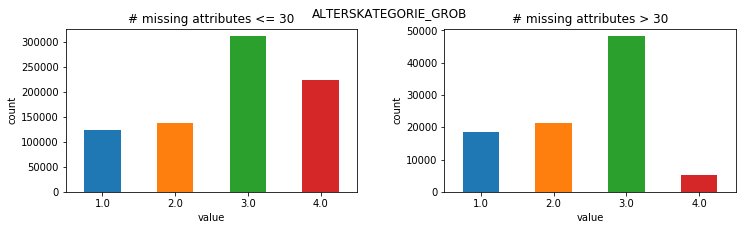

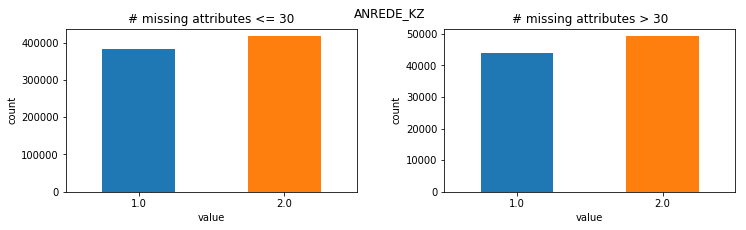

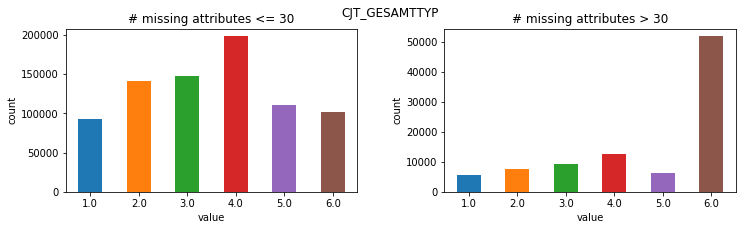

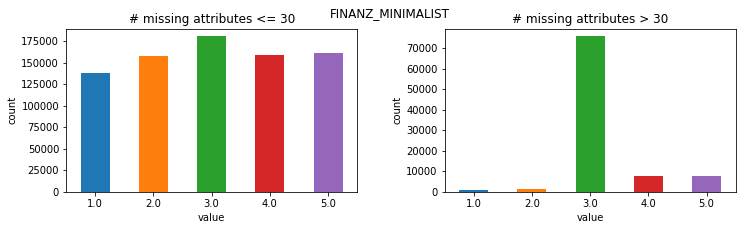

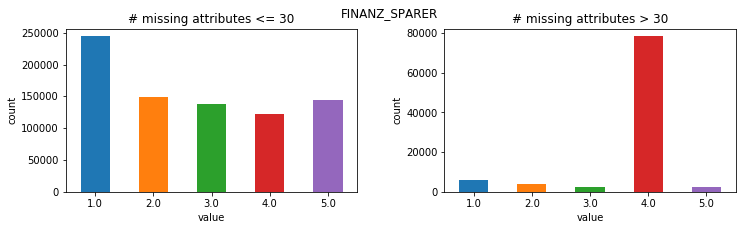

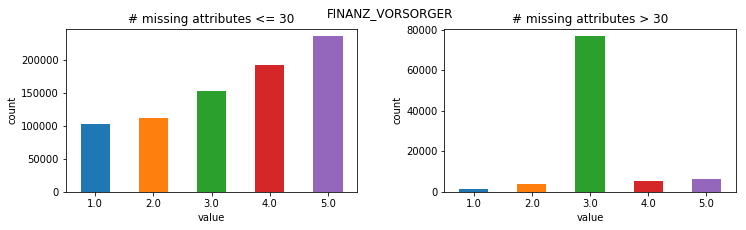

In [10]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_distributions(df_low, df_high, column_name):
    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(column_name)
    df_low[column_name].value_counts().sort_index(axis=0).plot(kind='bar', ax=ax[0], rot=0)
    ax[0].set(title="# missing attributes <= 30", xlabel="value", ylabel="count")
    
    df_high[column_name].value_counts().sort_index(axis=0).plot(kind='bar', ax=ax[1], rot=0)
    ax[1].set(title="# missing attributes > 30", xlabel="value", ylabel="count")
       
    plt.show()

for column in azdias.columns[0:6]:
    plot_distributions(azdias_low_missing,azdias_high_missing,column)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

As shown, 268012 out of 891221 rows of data have missing features, which is around 30% of the data. The histogram shows that most of the data either has 20 or less missing features or more than 30, so there is a split in the data. The majority of the data have 10 or less missing features, while a very small percentage have 30-50 missing features, with no rows having over 50.

If you consider 30 as the split threshold, the data can be split into two sets: one set with a high number of missing features, and the other with a low number of missing features. The set with the low number of missing features has around 90% of the data, while the set with the high number of missing features has around 10% of the data.

As shown from the bar graphs above, the data from the set of higher number of missing features is differently distributed than the set with the low number of missing features. Since this is only around 10% of the data, it should be taken out so as to no influence the results by affecting the distribution as a whole.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [11]:
# How many features are there of each data type?

feature_types = feat_info['type'].value_counts()
display(feature_types)

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_categories = {}
multilevel_categories = {}
for column in feat_info[feat_info['type']=='categorical'].attribute:
    if column in azdias_low_missing.columns:
        if azdias[column].nunique() == 2:
            binary_categories[column] = azdias_low_missing[column].unique()
        if azdias[column].nunique() > 2:
            multilevel_categories[column] = len(azdias_low_missing[column].unique())

print('binary categories (name -> values):')
display(binary_categories)

print('multilevel categories (name -> numValues):')
display(multilevel_categories)


binary categories (name -> values):


{'ANREDE_KZ': array([ 2.,  1.]),
 'GREEN_AVANTGARDE': array([ 0.,  1.]),
 'SOHO_KZ': array([ 1.,  0.]),
 'VERS_TYP': array([  2.,   1.,  nan]),
 'OST_WEST_KZ': array(['W', 'O'], dtype=object)}

multilevel categories (name -> numValues):


{'CJT_GESAMTTYP': 7,
 'FINANZTYP': 6,
 'GFK_URLAUBERTYP': 13,
 'LP_FAMILIE_FEIN': 12,
 'LP_FAMILIE_GROB': 6,
 'LP_STATUS_FEIN': 11,
 'LP_STATUS_GROB': 6,
 'NATIONALITAET_KZ': 4,
 'SHOPPER_TYP': 5,
 'ZABEOTYP': 6,
 'GEBAEUDETYP': 7,
 'CAMEO_DEUG_2015': 10,
 'CAMEO_DEU_2015': 45}

In [13]:
# Re-encode categorical variable(s) to be kept in the analysis.

dict_bin_enc = {'W': 0, 'O': 1}
azdias_low_missing['OST_WEST_KZ'].replace(dict_bin_enc, inplace=True)
print('updated encoding of the binary categorical variable: ', azdias_low_missing['OST_WEST_KZ'].unique())

azdias_low_missing.drop(multilevel_categories.keys(), axis=1, inplace=True)

print('num binary categorical variables: ', len(binary_categories.keys()))
print('num dropped multilevel categorical variables: ', len(multilevel_categories.keys()))
display(azdias_low_missing.head())

updated encoding of the binary categorical variable:  [0 1]
num binary categorical variables:  5
num dropped multilevel categorical variables:  13


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The dataset originally had 21 categorical columns. After dropping 6 columns earlier, the remaining dataset had 79 columns with 18 being categorical columns. There were 5 binary columns and 13 multilevel columns. The multilevel columns were dropped to leave the remaining 5 binary columns and the resulting dataset has 66 columns total.
Column OST_WEST_KZ needed to be re-encoded to numerical binary values and it has values [0,1]

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [14]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print('values of the PRAEGENDE_JUGENDJAHRE column in the dataset:\n', azdias_low_missing['PRAEGENDE_JUGENDJAHRE'].unique())

dict_decade = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
azdias_low_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_low_missing['PRAEGENDE_JUGENDJAHRE'].replace(dict_decade)

avantgarde = 0
mainstream = 1
dict_movement= {1:mainstream, 2:avantgarde, 3:mainstream, 4:avantgarde, 5:mainstream, 6:avantgarde, 7:avantgarde, 8:mainstream, 9:avantgarde, 10:mainstream, 11:avantgarde, 12:mainstream, 13:avantgarde, 14:mainstream, 15:avantgarde}
azdias_low_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_low_missing['PRAEGENDE_JUGENDJAHRE'].replace(dict_movement)

print('dataset after engineering PRAEGENDE_JUGENDJAHRE:')
display(azdias_low_missing.head())


values of the PRAEGENDE_JUGENDJAHRE column in the dataset:
 [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]
dataset after engineering PRAEGENDE_JUGENDJAHRE:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,70.0,1.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0


In [15]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


print('values of the CAMEO_INTL_2015 column in the dataset:\n', azdias_low_missing['CAMEO_INTL_2015'].unique())


azdias_low_missing['CAMEO_INTL_2015_WEALTH'] = azdias_low_missing['CAMEO_INTL_2015'].apply(lambda x: int(x) // 10 if pd.notnull(x) else x)


azdias_low_missing['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_low_missing['CAMEO_INTL_2015'].apply(lambda x: int(x) % 10 if pd.notnull(x) else x)

print('dataset after engineering CAMEO_INTL_2015:')
display(azdias_low_missing.head())


values of the CAMEO_INTL_2015 column in the dataset:
 ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
dataset after engineering CAMEO_INTL_2015:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,70.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The main dataset has a total of 6 columns with mixed values. For each of the two columns 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015', I introduced two new columns that separate the aspects combined by each of these mixed columns as follows:

For 'PRAEGENDE_JUGENDJAHRE', two new columns are added which reflect 'decade' and 'movement' aspects.
For 'CAMEO_INTL_2015', two new columns are added which reflect 'wealth' and 'life-stage' aspects.
After introducing the above 4 new columns, the 6 mixed columns are dropped from the dataset, which would have contained data already made available in these new columns.

At the end, we have a dataset with 64 columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [16]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

mixed_categories = {}
for column in feat_info[feat_info['type']=='mixed'].attribute:
    if column in azdias_low_missing.columns:
        mixed_categories[column] = azdias_low_missing[column].unique()
        print(column, ": ", len(mixed_categories[column]))
        
print('dropping ', len(mixed_categories), ' mixed columns:\n', mixed_categories.keys())

azdias_low_missing.drop(mixed_categories.keys(), axis=1, inplace=True)


print('dataset after dropping mixed columns:')
display(azdias_low_missing.head())

LP_LEBENSPHASE_FEIN :  41
LP_LEBENSPHASE_GROB :  13
PRAEGENDE_JUGENDJAHRE :  16
WOHNLAGE :  8
CAMEO_INTL_2015 :  22
PLZ8_BAUMAX :  6
dropping  6  mixed columns:
 dict_keys(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'])
dataset after dropping mixed columns:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,70.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0,5.0,4.0


In [17]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

display(azdias_low_missing.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,70.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [18]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # code to execute all main cleaning steps:
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

    # convert missing value codes into NaNs
    dict_replacements = {}
    for attribute, missing_or_unknown in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        missing_items = missing_or_unknown.strip('[]').split(',')
        if(len(missing_items)>0):
            dict_replacements[attribute] = len(df[df[attribute].isin(missing_items)])
            df.loc[df[attribute].isin(missing_items), attribute] = np.nan
            
    # remove selected columns and rows
    
    ## columns
    
    outlier_cols = ['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
    df.drop(outlier_cols, axis=1, inplace=True)    
    
    ## rows
    split_threshold = 25
    df_low_missing = df[df.isnull().sum(axis=1) <= 25]
    df_high_missing = df[df.isnull().sum(axis=1) > 25]
    
    # select, re-encode, and engineer column values.
    
    ## binary variables
    binary_categories = {}
    multilevel_categories = {}
    for column in feat_info[feat_info['type']=='categorical'].attribute:
        if column in df_low_missing.columns:
            if df[column].nunique() == 2:
                binary_categories[column] = df_low_missing[column].unique()
            if df[column].nunique() > 2:
                multilevel_categories[column] = df_low_missing[column].unique()
     ### 1) handling the binary categorical variable that must be re-encoded
    dict_bin_enc = {'W': 0, 'O': 1}
    df_low_missing.loc[:,'OST_WEST_KZ'].replace(dict_bin_enc, inplace=True)

    ### 2) dropping multilevel categorical variables
    df_low_missing.drop(multilevel_categories.keys(), axis=1, inplace=True)
    
    ## mixed variables 
    
    ### 1) engineering the decade and movement aspects of feature PRAEGENDE_JUGENDJAHRE
    dict_decade = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    df_low_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_low_missing['PRAEGENDE_JUGENDJAHRE'].replace(dict_decade)

    avantgarde = 0
    mainstream = 1
    dict_movement= {1:mainstream, 2:avantgarde, 3:mainstream, 4:avantgarde, 5:mainstream, 6:avantgarde, 7:avantgarde, 8:mainstream, 9:avantgarde, 10:mainstream, 11:avantgarde, 12:mainstream, 13:avantgarde, 14:mainstream, 15:avantgarde}
    df_low_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_low_missing['PRAEGENDE_JUGENDJAHRE'].replace(dict_movement)

    ### 2) engineering the wealth and life-stage aspects of feature CAMEO_INTL_2015
    df_low_missing['CAMEO_INTL_2015_WEALTH'] = df_low_missing['CAMEO_INTL_2015'].apply(lambda x: int(x) // 10 if pd.notnull(x) else x)
    df_low_missing['CAMEO_INTL_2015_LIFE_STAGE'] = df_low_missing['CAMEO_INTL_2015'].apply(lambda x: int(x) % 10 if pd.notnull(x) else x)

    ### 3) dropping mixed variables
    mixed_categories = {}
    for column in feat_info[feat_info['type']=='mixed'].attribute:
        if column in df_low_missing.columns:
            mixed_categories[column] = df_low_missing[column].unique()
    df_low_missing.drop(mixed_categories.keys(), axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_low_missing
    


In [19]:
azdias_dup = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
population_df = clean_data(azdias_dup)
display(population_df.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,70.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [20]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer(strategy="median")
population_df = pd.DataFrame(imputer.fit_transform(population_df), columns = population_df.columns)
print('num remaining NaN after imputation: ', population_df.isnull().sum(axis=0).sum())

num remaining NaN after imputation:  0


In [21]:
# Apply feature scaling to the general population demographics data.
stdScaler = StandardScaler()
population_df = pd.DataFrame(stdScaler.fit_transform(population_df), columns = population_df.columns)
display(population_df.describe())


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,...,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05,7.979610e+05
mean,9.883972e-19,-6.482016e-17,-9.794927e-19,1.301657e-16,1.510689e-16,-7.861320e-17,6.868025e-17,-1.657836e-16,7.746007e-17,3.118349e-16,...,-7.588397e-17,-1.300232e-16,2.708743e-17,1.584997e-16,6.862237e-17,-4.692215e-17,2.953082e-16,-7.746007e-17,-8.120885e-18,1.534776e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766616e+00,-1.043914e+00,-1.494605e+00,-1.155482e+00,-1.766963e+00,-1.249960e+00,-1.184858e+00,-1.501540e+00,-5.304422e-01,-1.610602e+00,...,-9.856398e-01,-2.728110e+00,-2.160117e+00,-2.173492e+00,-1.868113e+00,-1.526014e+00,-2.317978e+00,-1.885219e+00,-1.552980e+00,-1.266976e+00
25%,-7.830433e-01,-1.043914e+00,-7.686846e-01,-1.155482e+00,-1.040689e+00,-1.249960e+00,-1.184858e+00,-7.913466e-01,-5.304422e-01,-2.570259e-01,...,-9.856398e-01,-6.488407e-01,-3.372184e-01,-1.664319e-01,-5.623343e-01,-7.890585e-01,-9.216222e-01,5.304422e-01,-8.681823e-01,-1.266976e+00
50%,2.005292e-01,9.579333e-01,-4.276408e-02,1.912504e-01,4.118594e-01,1.080440e-01,-4.702992e-01,-8.115294e-02,-5.304422e-01,-2.570259e-01,...,4.066384e-01,3.907941e-01,-3.372184e-01,-1.664319e-01,-1.270747e-01,-5.210290e-02,-2.234444e-01,5.304422e-01,5.014131e-01,8.518887e-02
75%,1.184102e+00,9.579333e-01,6.831564e-01,8.646166e-01,1.138133e+00,7.870460e-01,9.588178e-01,6.290407e-01,-5.304422e-01,1.096551e+00,...,4.066384e-01,3.907941e-01,5.742308e-01,8.370981e-01,7.434444e-01,6.848527e-01,1.172911e+00,5.304422e-01,1.186211e+00,7.612714e-01
max,1.184102e+00,9.579333e-01,1.409077e+00,1.537983e+00,1.138133e+00,1.466048e+00,1.673376e+00,1.339234e+00,1.885219e+00,1.096551e+00,...,1.798916e+00,1.430429e+00,1.485680e+00,1.840628e+00,1.613964e+00,1.421808e+00,1.172911e+00,5.304422e-01,1.186211e+00,1.437354e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

For missing values, I used Imputer to find the median of the column values and used that to fill the missing value.

I chose to use this median strategy because the median of the values provides a close estimate of the data's average values. Therefore, when filling the missing data, the new values would not deviate too far from the values that are present and not change further analysis.

For feature scaling, I applied StandardScaler.
Feature scaling is applied to make sure that the algorithm is not biased to higher values. This helps the gradient descent flow smoother.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [22]:
# Apply PCA to the data.

pca = PCA()
pca_model = pca.fit_transform(population_df)


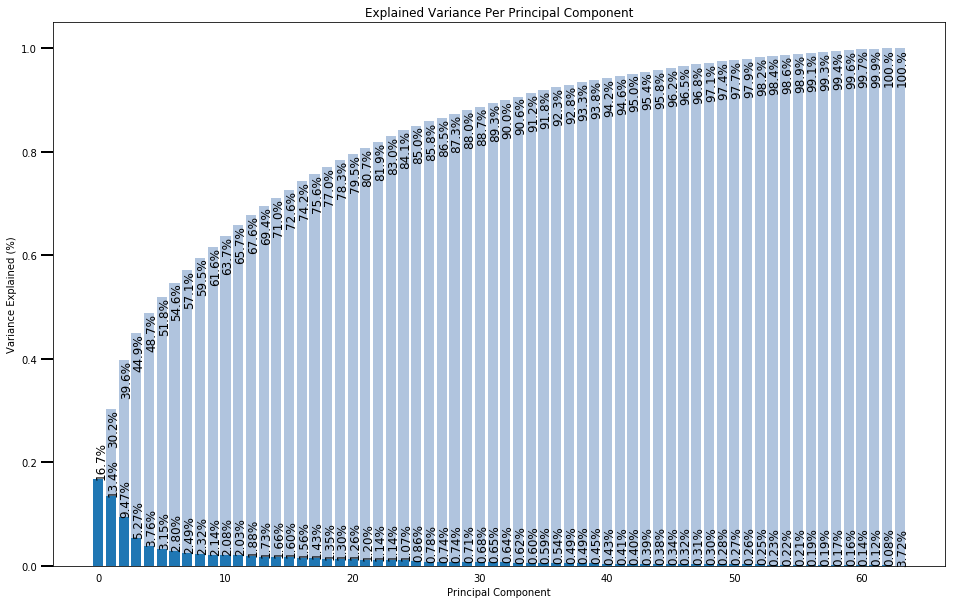

In [23]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    
    ax.bar(ind, cumvals, color='lightsteelblue')
    for i in range(1,num_components):
        ax.annotate(r"%s%%" % ((str(cumvals[i]*100)[:4])), (ind[i]+0.2, cumvals[i]), rotation=90, va="top", ha="center", fontsize=12)
        
    ax.bar(ind, vals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), rotation=90, va="bottom", ha="center", fontsize=12)
    
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [24]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_pca_comp = 35
pca = PCA(n_components=n_pca_comp)
pca_population = pca.fit_transform(population_df)
total_variance = pca.explained_variance_ratio_.sum()
print("selected" ,  n_pca_comp, "components to achieve a total variance >=90\%. ", total_variance)


selected 35 components to achieve a total variance >=90\%.  0.912425760892


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I am retaining a variance of >=90% which is the first 35 components for the next step of the analysis..

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [25]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_weights(column_names, pca, component_index):
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = column_names)
    components.index = dimensions
    # Weights
    weights = components.iloc[component_index].sort_values(ascending=False)
    
    return weights

display(get_weights(population_df.columns, pca, 0))


PLZ8_ANTG3                        0.2271
PLZ8_ANTG4                        0.2203
CAMEO_INTL_2015_WEALTH            0.2075
HH_EINKOMMEN_SCORE                0.2040
ORTSGR_KLS9                       0.1983
EWDICHTE                          0.1966
FINANZ_HAUSBAUER                  0.1631
KBA05_ANTG4                       0.1562
PLZ8_ANTG2                        0.1548
ARBEIT                            0.1443
FINANZ_SPARER                     0.1435
KBA05_ANTG3                       0.1386
ANZ_HAUSHALTE_AKTIV               0.1373
RELAT_AB                          0.1362
SEMIO_PFLICHT                     0.1123
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.1095
SEMIO_REL                         0.1094
PRAEGENDE_JUGENDJAHRE_DECADE      0.0969
SEMIO_RAT                         0.0921
SEMIO_TRADV                       0.0857
SEMIO_MAT                         0.0763
SEMIO_FAM                         0.0756
FINANZ_UNAUFFAELLIGER             0.0711
SEMIO_KULT                        0.0697
REGIOTYP        

In [26]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display(get_weights(population_df.columns, pca, 1))

ALTERSKATEGORIE_GROB              0.2611
FINANZ_VORSORGER                  0.2339
SEMIO_ERL                         0.2315
SEMIO_LUST                        0.1844
RETOURTYP_BK_S                    0.1640
W_KEIT_KIND_HH                    0.1194
FINANZ_HAUSBAUER                  0.1160
SEMIO_KRIT                        0.1155
SEMIO_KAEM                        0.1121
ANREDE_KZ                         0.0905
EWDICHTE                          0.0886
PLZ8_ANTG3                        0.0881
ORTSGR_KLS9                       0.0870
PLZ8_ANTG4                        0.0841
CAMEO_INTL_2015_WEALTH            0.0715
SEMIO_DOM                         0.0709
KBA05_ANTG4                       0.0695
FINANZ_MINIMALIST                 0.0681
ARBEIT                            0.0652
RELAT_AB                          0.0628
ANZ_HAUSHALTE_AKTIV               0.0612
WOHNDAUER_2008                    0.0612
PLZ8_ANTG2                        0.0610
HH_EINKOMMEN_SCORE                0.0541
KBA05_ANTG3     

In [27]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

display(get_weights(population_df.columns, pca, 2))

SEMIO_VERT                        0.3451
SEMIO_SOZ                         0.2621
SEMIO_FAM                         0.2497
SEMIO_KULT                        0.2349
FINANZ_MINIMALIST                 0.1559
RETOURTYP_BK_S                    0.1089
FINANZ_VORSORGER                  0.1014
W_KEIT_KIND_HH                    0.0913
ALTERSKATEGORIE_GROB              0.0794
SEMIO_REL                         0.0691
SEMIO_LUST                        0.0648
SEMIO_MAT                         0.0557
GREEN_AVANTGARDE                  0.0474
ORTSGR_KLS9                       0.0467
EWDICHTE                          0.0461
PLZ8_ANTG4                        0.0452
PLZ8_ANTG3                        0.0449
ARBEIT                            0.0350
WOHNDAUER_2008                    0.0329
RELAT_AB                          0.0319
PLZ8_ANTG2                        0.0301
KBA05_ANTG4                       0.0285
CAMEO_INTL_2015_WEALTH            0.0278
ANZ_HAUSHALTE_AKTIV               0.0254
OST_WEST_KZ     

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


Principal Component #0

The first principal components reflects a positive correlation between components like: PLZ8_ANTG3, PLZ8_ANTG4, CAMEO_INTL_2015_WEALTH, HH_EINKOMMEN_SCORE, ORTSGR_KLS9, and EWDICHTE. It is negatively correlated with components like: MOBI_REGIO, PLZ8_ANTG1, KBA05_ANTG1, FINANZ_MINIMALIST, and KBA05_GBZ.
According to Data_Dictionary.md, these properties mostly correpsond to the population density and houshold size in the area as well as the wealth.

Principal Component #1

The first principal components reflects a positive correlation between components like: ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL, SEMIO_LUST, and RETOURTYP_BK_S. It is negatively correlated with components like: SEMIO_REL, PRAEGENDE_JUGENDJAHRE_DECADE, FINANZ_SPARER, SEMIO_TRADV, SEMIO_PFLICHT, and FINANZ_UNAUFFAELLIGER.
According to  Data_Dictionary.md, these properties mostly correpsond to the age, the personality and the shopping behavior of individuals.


Principal Component #2

The first principal components reflects a positive correlation between components like: SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, and FINANZ_MINIMALIST. It is negatively correlated with components like: ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT, FINANZ_ANLEGER, and SEMIO_ERL.
According to Data_Dictionary.md, these properties correpsond to the personality of the individual , their shopping behavior, gender, and their attitude.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [28]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    
def run_clustering(dataset, min_k, max_k):
    k_values = list(range(min_k, max_k+1))
    scores = []
    for k in k_values:
        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(dataset)
        
        # compute the average within-cluster distances.
        score = np.abs(model.score(dataset))
        scores.append(score)
        print('k=',k,': score=', score)
    return k_values, scores

k_values, scores = run_clustering(pca_population, 2, 15)
    
    

k= 2 : score= 40164198.2517
k= 3 : score= 36880069.472
k= 4 : score= 34798348.3069
k= 5 : score= 33321989.3029
k= 6 : score= 32072552.8583
k= 7 : score= 30937210.9663
k= 8 : score= 30079172.4005
k= 9 : score= 29484289.4146
k= 10 : score= 28907996.3358
k= 11 : score= 28306460.5821
k= 12 : score= 27740888.0577
k= 13 : score= 27461441.7324
k= 14 : score= 27078892.4755
k= 15 : score= 26791069.8271


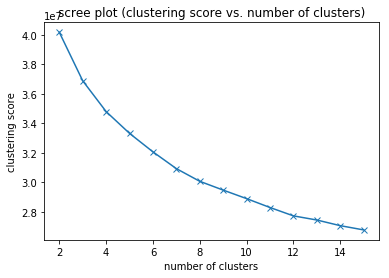

In [29]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(k_values, scores, marker="x")
plt.ylabel('clustering score');
plt.xlabel('number of clusters');
plt.title('scree plot (clustering score vs. number of clusters)');

In [30]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=9)
kmeans_model = kmeans.fit(pca_population)
prediction_population = kmeans_model.predict(pca_population)
prediction_population

array([6, 5, 5, ..., 3, 4, 7], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)


I used a scree plot to visualize the clustering score as a function of the number of clusters. I choose k = 9 for the number of clusters to segment the population since there seems to be a steeper dip after k = 9.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [31]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=";")
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [32]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

preproc_customers_df = clean_data(customers)
print('customer df shape:', preproc_customers_df.shape)
preproc_customers_df = pd.DataFrame(imputer.transform(preproc_customers_df), columns = preproc_customers_df.columns)
preproc_customers_df = pd.DataFrame(stdScaler.transform(preproc_customers_df), columns = preproc_customers_df.columns)
display(preproc_customers_df.head())

# sanity check
if len(list(set(population_df.columns) - set(preproc_customers_df))) > 0:
    print('sanity check failed.')
    
# clustering
print('clustering result:')
preproc_customers_df_pca = pca.transform(preproc_customers_df)
prediction_customers = kmeans_model.predict(preproc_customers_df_pca)
prediction_customers

customer df shape: (141713, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1.184102,-1.043914,1.409077,-1.155482,1.138133,-1.249960,-0.470299,-0.791347,1.885219,-1.610602,...,-0.985640,1.430429,1.485680,-2.173492,-1.432853,-1.526014,-1.619800,-1.885219,-1.552980,0.085189
1,1.184102,0.957933,1.409077,-1.155482,1.138133,-1.249960,0.958818,0.629041,1.885219,-0.257026,...,0.406638,-0.648841,-1.248668,-0.166432,-0.127075,-0.052103,-1.619800,-1.885219,-0.183385,0.761271
2,1.184102,-1.043914,1.409077,-1.155482,1.138133,-0.570958,-1.184858,-0.791347,-0.530442,-0.257026,...,-0.985640,-0.648841,0.574231,-2.173492,-0.997594,-1.526014,-2.317978,0.530442,-0.868182,0.761271
3,0.200529,-1.043914,-0.042764,-1.155482,0.411859,0.787046,1.673376,-0.791347,-0.530442,1.096551,...,0.406638,-0.648841,-0.337218,-0.166432,-0.127075,-1.526014,-0.223444,0.530442,0.501413,-1.266976
4,0.200529,-1.043914,1.409077,-1.155482,1.138133,-1.249960,-0.470299,-0.081153,1.885219,1.096551,...,0.406638,1.430429,1.485680,-0.166432,0.743444,1.421808,-1.619800,-1.885219,-0.183385,0.761271


clustering result:


array([0, 8, 7, ..., 0, 5, 7], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

distribution of of data points in different clusters (\%):


,customer,population,difference
clusters,,,
0,33.565022,7.619796,-25.945226
1,10.905845,12.032292,1.126447
2,1.926429,7.912793,5.986364
3,1.963123,11.807720,9.844597
4,1.011199,8.514326,7.503127
5,19.170436,16.243150,-2.927286
6,1.107167,10.782482,9.675315
7,19.673566,11.592045,-8.081520
8,10.677214,13.495396,2.818183


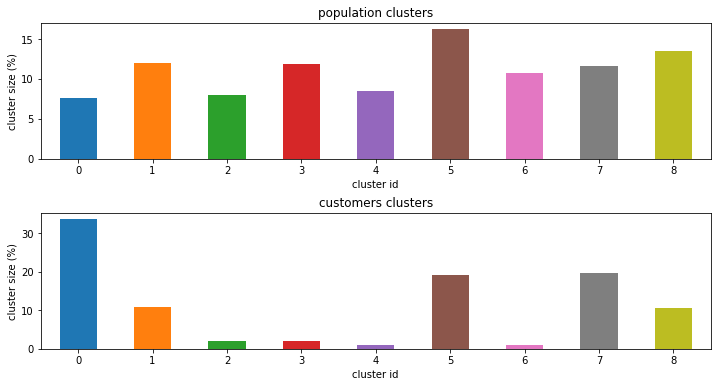

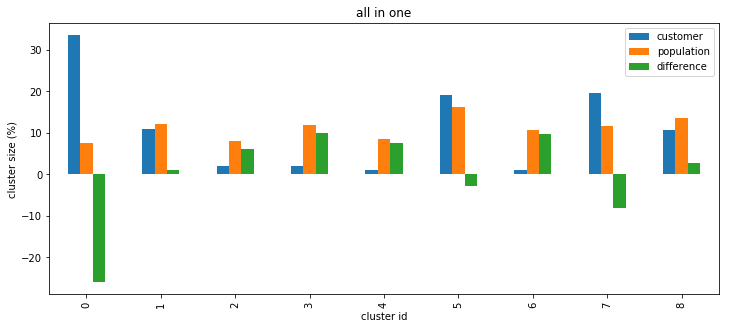

In [33]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

df_cluster_sizes = pd.DataFrame(prediction_customers, columns=['clusters']).reset_index().groupby('clusters').count()*100/len(prediction_customers)
df_cluster_sizes.rename({'index':'customer'}, axis=1, inplace=True)
df_cluster_sizes['population'] = pd.DataFrame(prediction_population, columns=['clusters']).reset_index().groupby('clusters').count()*100/len(prediction_population)
df_cluster_sizes['difference'] = df_cluster_sizes['population']-df_cluster_sizes['customer']

print('distribution of of data points in different clusters (\%):')
display(df_cluster_sizes)



fig, ax = plt.subplots(2,1, figsize=(12,6))
fig.subplots_adjust(hspace=0.4)
df_cluster_sizes['population'].plot(kind='bar', ax=ax[0], rot=0)
ax[0].set(title="population clusters", xlabel="cluster id", ylabel="cluster size (%)")


df_cluster_sizes['customer'].plot(kind='bar', ax=ax[1], rot=0)
ax[1].set(title="customers clusters", xlabel="cluster id", ylabel="cluster size (%)")

    
df_cluster_sizes.plot.bar(figsize=(12,5))
plt.ylabel('cluster size (%)')
plt.xlabel('cluster id')
plt.title('all in one')
plt.show()

In [34]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented_cluster_index = 4
overrepresented_cluster_members = pd.DataFrame(stdScaler.inverse_transform(pca.inverse_transform(preproc_customers_df_pca[np.where(prediction_customers==overrepresented_cluster_index)])).round(), columns=population_df.columns)
display(overrepresented_cluster_members.head())
display(overrepresented_cluster_members.describe())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,2.0,1.0,3.0,4.0,3.0,3.0,4.0,3.0,-0.0,1.0,...,2.0,3.0,1.0,3.0,8.0,4.0,84.0,1.0,4.0,1.0
1,2.0,1.0,3.0,2.0,3.0,1.0,2.0,3.0,1.0,2.0,...,0.0,3.0,3.0,4.0,8.0,4.0,76.0,0.0,4.0,5.0
2,2.0,1.0,2.0,5.0,1.0,4.0,3.0,4.0,0.0,3.0,...,2.0,4.0,2.0,4.0,9.0,3.0,92.0,1.0,4.0,1.0
3,2.0,1.0,3.0,2.0,3.0,2.0,1.0,3.0,0.0,3.0,...,2.0,3.0,1.0,3.0,6.0,2.0,75.0,1.0,5.0,4.0
4,2.0,1.0,4.0,2.0,3.0,2.0,2.0,3.0,0.0,1.0,...,1.0,4.0,3.0,4.0,7.0,3.0,73.0,1.0,4.0,5.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,...,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000
mean,2.087230,1.000698,2.466853,3.796232,2.521284,2.879274,3.379623,3.167481,0.247732,2.361479,...,1.434054,3.767620,2.531054,3.535939,7.430565,3.718074,83.390091,0.752268,4.138172,2.068388
std,0.761365,0.026417,0.890936,0.978291,0.980822,1.018719,1.173344,1.051005,0.431846,0.712397,...,0.587354,0.828785,0.906551,0.656084,1.459735,0.898518,8.097906,0.431846,0.937518,1.486743
min,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,-0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,57.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,...,1.000000,3.000000,2.000000,3.000000,7.000000,3.000000,77.000000,1.000000,4.000000,1.000000
50%,2.000000,1.000000,2.000000,4.000000,2.000000,3.000000,4.000000,3.000000,-0.000000,2.000000,...,1.000000,4.000000,3.000000,4.000000,8.000000,4.000000,86.000000,1.000000,4.000000,1.000000
75%,3.000000,1.000000,3.000000,5.000000,3.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,2.000000,4.000000,3.000000,4.000000,9.000000,4.000000,89.000000,1.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,6.000000,5.000000,6.000000,6.000000,1.000000,3.000000,...,3.000000,6.000000,5.000000,5.000000,10.000000,6.000000,101.000000,1.000000,6.000000,5.000000


In [35]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_cluster_index = 0
underrepresented_cluster_members = pd.DataFrame(stdScaler.inverse_transform(pca.inverse_transform(preproc_customers_df_pca[np.where(prediction_customers==underrepresented_cluster_index)])).round(), columns=population_df.columns)
display(underrepresented_cluster_members.head())
display(underrepresented_cluster_members.describe())


mean_df = pd.DataFrame(overrepresented_cluster_members.mean(), columns=['cluster 4 (over)'])
mean_df['cluster 0 (under)'] = pd.DataFrame(underrepresented_cluster_members.mean())
mean_df['PC0 weight'] = pd.DataFrame(get_weights(population_df.columns, pca, 0))

mean_df.sort_values(['PC0 weight'], ascending=False, inplace=True)
mean_df

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,3.0,0.0,56.0,0.0,1.0,3.0
1,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,4.0,5.0,5.0,59.0,-0.0,2.0,4.0
2,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,57.0,0.0,2.0,3.0
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,1.0,3.0,3.0,3.0,4.0,3.0,56.0,-0.0,1.0,5.0
4,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,0.0,5.0,5.0,3.0,7.0,3.0,74.0,0.0,1.0,5.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,...,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000,47566.000000
mean,3.521927,1.004604,4.933566,1.217445,4.734832,1.073729,1.867342,2.124774,0.991885,1.843754,...,0.430833,3.707985,3.843754,2.881596,5.323004,2.942017,61.044906,0.008115,1.951436,3.702056
std,0.580104,0.067698,0.468498,0.619389,0.707076,0.792167,0.726269,0.842656,0.089718,0.832898,...,0.519279,0.922247,0.873025,0.979246,1.633646,1.340270,7.570812,0.089718,1.126833,1.121294
min,1.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,...,-1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,47.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,5.000000,1.000000,5.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,0.000000,3.000000,3.000000,2.000000,4.000000,2.000000,56.000000,-0.000000,1.000000,3.000000
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,4.000000,4.000000,3.000000,5.000000,3.000000,59.000000,0.000000,2.000000,4.000000
75%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,3.000000,...,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000,63.000000,0.000000,3.000000,4.000000
max,5.000000,2.000000,6.000000,5.000000,6.000000,5.000000,6.000000,6.000000,1.000000,3.000000,...,2.000000,6.000000,6.000000,5.000000,9.000000,6.000000,97.000000,1.000000,6.000000,6.000000


,cluster 4 (over),cluster 0 (under),PC0 weight
PLZ8_ANTG3,2.526867,1.262120,0.2271
PLZ8_ANTG4,1.434054,0.430833,0.2203
CAMEO_INTL_2015_WEALTH,4.138172,1.951436,0.2075
HH_EINKOMMEN_SCORE,4.975576,2.231993,0.2040
ORTSGR_KLS9,7.430565,5.323004,0.1983
EWDICHTE,5.572226,4.017870,0.1966
FINANZ_HAUSBAUER,3.167481,2.124774,0.1631
KBA05_ANTG4,0.630844,0.006770,0.1562
PLZ8_ANTG2,3.329379,2.663751,0.1548
ARBEIT,3.535939,2.881596,0.1443


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The cluster sizes for the customer dataset suggest that the clusters 4 and 1 are overrepresented in the customers dataset. Thus, the individuals in these clusters are particularly good targets for the mail-oder company to focus on. Particularly, cluster 4 constitutes the most attractive customer segment.

On the other hand, the clusters 0, 8, 7, and 2 are underrepresented in the customers dataset. Thus, the individuals in these clusters are less likely to become mail-order customers and, therefore, are not attractive targets for the company to focus on.

The first principal component gives us the highest positive weights for the following features:

PLZ8_ANTG3 and PLZ8_ANTG4: the higher, the more populated homes
CAMEO_INTL_2015_WEALTH: the lower, the wealthier
HH_EINKOMMEN_SCORE: the lower, the higher household net income
and, the highest negative weights for the following features:

MOBI_REGIO: the higher, the more movement
PLZ8_ANTG1, KBA05_ANTG1: the higher, the more under-populated homes
FINANZ_MINIMALIST: the higher, the lower financial interest
KBA05_GBZ: the higher, the higher the density of buildings in the microcell
(the description of the features is derived from the Data_Dictionary.md)

By comparing an overrepresented cluster (here, cluster 4) and an underpresented cluster (here, cluster 0) in the order of these weights, we see that the more attractive targets for the company (in cluster 4), generally have a smaller family size and a higher income level compared to the attractive segment (in cluster 0).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.